# Monthly seasonal forecasts

<b>Table of Contents</b>

- Overview
- Setup
    - Get authentication token
- Data layers
    - Data layer dimensions
- Querying the data layers
    - Point query
    - Raster query
- References
  
## Overview

The TWC Seasonal PFP offering consists of 50 equally likely scenarios. Maximum, minimum and average temperature, as well as total precipitation forecasts, are offered, extending out to 6-months at daily resolution. Forecasts are produced at monthly intervals (corresponding to the valid times of the forecasts), spanning from 01-01-2015 to present. The underlying data source is from the ECMWF-S5 climate model, which is calibrated against the ERA5 dataset.This dataset is used to compare current or forecasted weather data with historical climate benchmark and observe how much it varies with the historical norm as demonstrated in [this](../../weather_forecast/twc_spfp_weather_prediction.ipynb) tutorial.

## Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample, mentioned in the cell below.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../../../auth/secrets.ini')```

In [ ]:
%pip install ibmpairs
%pip install configparser
%pip install matplotlib

In [2]:
import ibmpairs.client as client
import ibmpairs.catalog as catalog
import ibmpairs.query as query
import pandas as pd
import configparser
import json
import numpy as np
from PIL import Image as PILImage
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os

Now, let us create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

### Get authentication token

In [3]:
config = configparser.RawConfigParser()
config.read('../../../../auth/secrets.ini')
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY    = config.get('EI', 'api.api_key')
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_ORG_ID     = config.get('EI', 'api.org_id')  

EI_client_v3  = client.get_client(api_key   = EI_API_KEY,
                                    tenant_id = EI_TENANT_ID,
                                    org_id    = EI_ORG_ID,
                                    legacy    = False,
                                    version   = 3
                                   )

2025-01-20 19:13:33 - paw - INFO - The client authentication method is assumed to be OAuth2.
2025-01-20 19:13:33 - paw - INFO - Legacy Environment is False
2025-01-20 19:13:33 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2025-01-20 19:13:40 - paw - INFO - Authentication success.
2025-01-20 19:13:40 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


## Data layers
We shall start by querying the catalog to retrieve the Data Set ID and the Data Layers that form the dataset.

In [97]:
pd.set_option('display.max_colwidth', None)
search_df=catalog.search("Monthly seasonal forecasts")
search_df[['dataset_id','data_layer_id','data_layer_name','data_layer_description_short','data_layer_level','data_layer_type','data_layer_unit','data_set_name','data_set_description_short']]

,dataset_id,data_layer_id,data_layer_name,data_layer_description_short,data_layer_level,data_layer_type,data_layer_unit,data_set_name,data_set_description_short
0,466,50686,Total precipitation,"Precipitation (daily total) from IBMs Calibrated Seasonal Probabilistic Forecast (SPFP). Contains 50 prototypes (i.e., ensemble members) plus prototype mean and std dev.",11,Raster,,Monthly seasonal forecasts,"Seasonal forecasts that include maximum, minimum and average temperature, and total precipitation forecasts. Forecasts are produced at monthly intervals from February 1981 to present."
1,466,50683,Minimum temperature,"2m temperature (daily minimum) from IBMs Calibrated Seasonal Probabilistic Forecast (SPFP). Contains 50 prototypes (i.e., ensemble members) plus prototype mean and std dev.",11,Raster,,Monthly seasonal forecasts,"Seasonal forecasts that include maximum, minimum and average temperature, and total precipitation forecasts. Forecasts are produced at monthly intervals from February 1981 to present."
2,466,50684,Maximum temperature,"2m temperature (daily maximum) from IBMs Calibrated Seasonal Probabilistic Forecast (SPFP). Contains 50 prototypes (i.e., ensemble members) plus prototype mean and std dev.",11,Raster,,Monthly seasonal forecasts,"Seasonal forecasts that include maximum, minimum and average temperature, and total precipitation forecasts. Forecasts are produced at monthly intervals from February 1981 to present."
3,466,50685,Average temperature,"2m temperature (daily average) from IBMs Calibrated Seasonal Probabilistic Forecast (SPFP). Contains 50 prototypes (i.e., ensemble members) plus prototype mean and std dev.",11,Raster,,Monthly seasonal forecasts,"Seasonal forecasts that include maximum, minimum and average temperature, and total precipitation forecasts. Forecasts are produced at monthly intervals from February 1981 to present."
4,466,51219,Model Elevation,"Model elevation to be used for temperature lapse rate downscaling. Please note this elevation is from the ERA5 model, not SEAS5.",12,Raster,,Monthly seasonal forecasts,"Seasonal forecasts that include maximum, minimum and average temperature, and total precipitation forecasts. Forecasts are produced at monthly intervals from February 1981 to present."


As seen above, the Monthly seasonal forecasts Data Set of ID 466 has 5 Data Layers. Each of the data layers are identified by a unique Data Layer ID. The elevation Data Layer 51219 is used to adjust temperature measurements based on an adiabatic lapse rate scaling which is beyond the scope of this tutorial. To gain a better understanding of the Data Set and its geospatial and temporal coverage as well as other relevant metadata, we can make further queries to the catalog submodule as mentioned in the [tutorials](https://ibm.github.io/ibmpairs/tutorials/quickstart/quickstartcatalog.html).

### Data layer dimensions
All Data Layers (except for Model elevation) have `forecast` and `horizon` as their dimensions. Their implications are listed below:
- `forecast` is an ensemble member/prototype refering to individual forecasts generated by different runs of the model, each representing a slightly different scenario based on variations in initial conditions, model configurations. It's possible values vary between 1-50, mean ( gives average of 50 predictions) and std (or standard deviation tells you how much variability there is in the 50 members).Ensemble forecasting allows users to quantify the uncertainty in their predictions. It’s a way to express the range of possible outcomes rather than providing a single deterministic forecast.
- `horizon` refers to the forecast lead time, or the number of time steps in the future for which the forecast is made. It's value range is 0-214 and if horizon is 15, we are querying weather for day 15 (starting from index 0) from a given start date. 


#### List of the data layer dimensions
<div style="display: inline-block">
    
| Data Layer ID |  Data Layer Name   | Dimensions | Dimensions Values|
|:---------------|:-------------------|:---------   |:-------------- |
| 50686         | Total precipitation  |   <b>forecast</b>|  Range between 1-50, mean, std   |              
|           |                    |  <b>horizon</b> |   Range between 0-214        |
| 50683             | Minimum temperature       |   <b>forecast</b>   |  Range between 1-50, mean, std  |             
|           |                    |  <b>horizon</b> |   Range between 0-214        |
| 50684             | Maximum temperature       |   <b>forecast</b>   |  Range between 1-50, mean, std  |         
|           |                    |  <b>horizon</b> |   Range between 0-214        |
| 50685             | Average temperature       |   <b>forecast</b>   |  Range between 1-50, mean, std  |            
|           |                    |  <b>horizon</b> |   Range between 0-214        |

</div>


## Querying the data layers

### Point query
Next, let us make a point query for locations in different parts of the world to observe their weather forecast.

In [99]:
query_result = query.submit(
    {
        "name": "test_twcsf_dimension_raster_point",
        "layers": [
            {
                "type": "raster",
                "id": 50683,
                "dimensions": [{"name": "forecast", "value": "mean"}, {"name": "horizon", "value": 15}]
            }, 
            {
                "type": "raster",
                "id": 50684,
                "dimensions": [{"name": "forecast","value": "01"}, {"name": "horizon","value": 16}]
            }, 
            {
                "type": "raster",
                "id": 50685,
                "dimensions": [{"name": "forecast","value": "30"}, {"name": "horizon","value": 17}]
            },
            {
                "type": "raster",
                "id": 50686,
                "dimensions": [ {"name": "forecast","value": "50"}, {"name": "horizon", "value": 18}]
            }
        ],
        "spatial": {
            "type": "point",
            "coordinates": [ 
                -11.332655, -52.821334,     #Brazil
                59.9665, 112.6031,          #Russia
                45.60306813, 5.5391408429   #France
            ]
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2024-04-01T00:00:00Z",
                    "end": "2024-05-31T00:00:00Z"
                }
            ]
        }
    } , client=EI_client_v3)

point_df = query_result.point_data_as_dataframe()
point_df['datetime'] = pd.to_datetime(point_df['timestamp'] , unit='ms', errors = 'coerce')
point_df['datetime'] = point_df['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
point_df = point_df.drop(columns=['timestamp'])
point_df

2025-01-13 12:43:08 - paw - INFO - TASK: submit STARTING.
2025-01-13 12:43:17 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,longitude,latitude,value,property,datetime
0,50683,Minimum temperature,Monthly seasonal forecasts,-52.821334,-11.332655,295.79229736328125,forecast:mean;horizon:15,2024-04-16T00:00:00Z
1,50683,Minimum temperature,Monthly seasonal forecasts,5.539141,45.603068,279.80816650390625,forecast:mean;horizon:15,2024-04-16T00:00:00Z
2,50683,Minimum temperature,Monthly seasonal forecasts,112.603100,59.966500,266.2919616699219,forecast:mean;horizon:15,2024-04-16T00:00:00Z
3,50683,Minimum temperature,Monthly seasonal forecasts,-52.821334,-11.332655,295.25396728515625,forecast:mean;horizon:15,2024-05-16T00:00:00Z
4,50683,Minimum temperature,Monthly seasonal forecasts,5.539141,45.603068,283.36083984375,forecast:mean;horizon:15,2024-05-16T00:00:00Z
5,50683,Minimum temperature,Monthly seasonal forecasts,112.603100,59.966500,277.2582092285156,forecast:mean;horizon:15,2024-05-16T00:00:00Z
6,50684,Maximum temperature,Monthly seasonal forecasts,-52.821334,-11.332655,303.7102966308594,forecast:01;horizon:16,2024-04-17T00:00:00Z
7,50684,Maximum temperature,Monthly seasonal forecasts,5.539141,45.603068,286.2295227050781,forecast:01;horizon:16,2024-04-17T00:00:00Z
8,50684,Maximum temperature,Monthly seasonal forecasts,112.603100,59.966500,268.0084228515625,forecast:01;horizon:16,2024-04-17T00:00:00Z
9,50684,Maximum temperature,Monthly seasonal forecasts,-52.821334,-11.332655,304.8955383300781,forecast:01;horizon:16,2024-05-17T00:00:00Z


We see above, the values for different climate variables that are obtained for various locations and dates we queried for. For instance, the location -11.332655, -52.821334 in Brazil that we queried for, with the start date as 01-04-2024 resulted in the value 295.79229736328125 K (which is the mean of all 50 ensemble members' predictions) for the Data Layer corresponding to Minimum temperature on the date 16-04-2024, which is 15 days from the given start date.

Note: The comments within the query JSON, intended for descriptive purposes, may cause compatibility issues in other programming languages and should be removed when using the data in those contexts.

### Raster query
Next, we shall make a raster query for a square area and observe it's weather characteristics.

In [91]:
TWCSFResult = query.submit_check_status_and_download(
    {
        "name": "TWCSF for Australia",
        "spatial": {
            "type": "square",
            "coordinates": [
                -34.926381, 117.053627, 
                -17.559765, 145.506492
            ]
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2024-11-01T00:00:00Z",
                    "end": "2024-11-31T00:00:00Z"
                }
            ]
        },
        "layers": [
            {
                "type": "raster",
                "id": 50683,
                "dimensions": [{"name": "forecast","value": "mean"}, {"name": "horizon","value": 15}]
            }, 
            {
                "type": "raster",
                "id": 50684,
                "dimensions": [{"name": "forecast","value": "mean"}, {"name": "horizon","value": 15}]
            }, 
            {
                "type": "raster",
                "id": 50685,
                "dimensions": [{"name": "forecast","value": "mean"}, {"name": "horizon","value": 15}]
            }, 
            {
                "type": "raster",
                "id": 50686,
                "dimensions": [{"name": "forecast","value": "mean"}, {"name": "horizon","value": 15}]
            }
        ]
    }
, client=EI_client_v3)

2025-01-07 17:13:44 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2025-01-07 17:13:46 - paw - INFO - The query was successfully submitted with the id: 1736208000_42226210.
2025-01-07 17:13:47 - paw - INFO - The query 1736208000_42226210 has the status Queued.
2025-01-07 17:14:18 - paw - INFO - The query 1736208000_42226210 has the status Succeeded.
2025-01-07 17:14:18 - paw - INFO - The query 1736208000_42226210 was successful after checking the status.
2025-01-07 17:14:49 - paw - INFO - The query 1736208000_42226210 has the status Succeeded.
2025-01-07 17:14:49 - paw - INFO - The query 1736208000_42226210 was successful after checking the status.
2025-01-07 17:14:49 - paw - INFO - The query download folder is set to the path /Users/environmental-intelligence/Environmental-Intelligence-internal/geospatial_analytics/v3_apis/samples/industry_use_cases/datasets/twc_seasonal_weather_forecast/download/.
2025-01-07 17:14:51 - paw - INFO - The query 1736208000_42226210 is a 

The query takes a few seconds to complete and downloads the output as a zip file in the /download folder within the same location as this notebook. Now we shall display the resultant tiff using the following utility function.

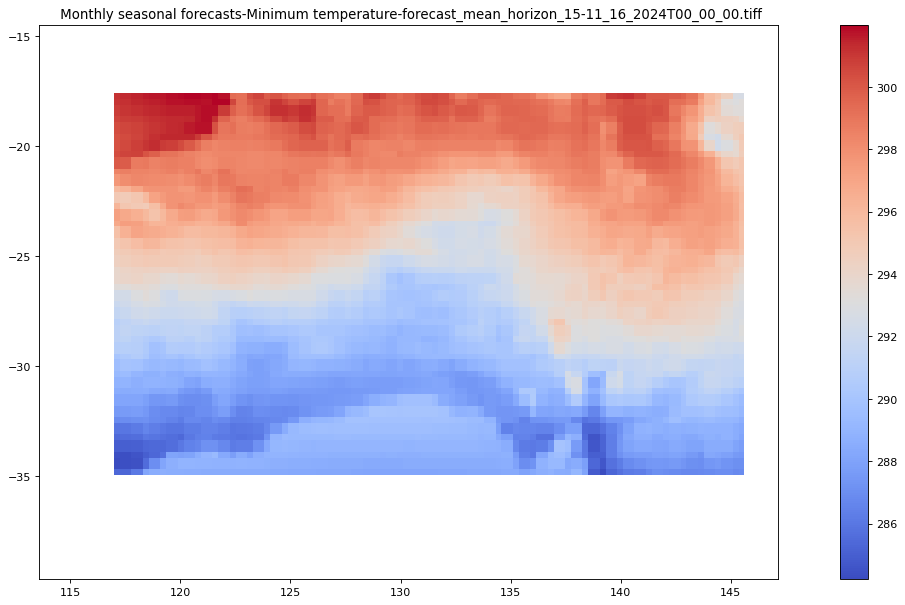

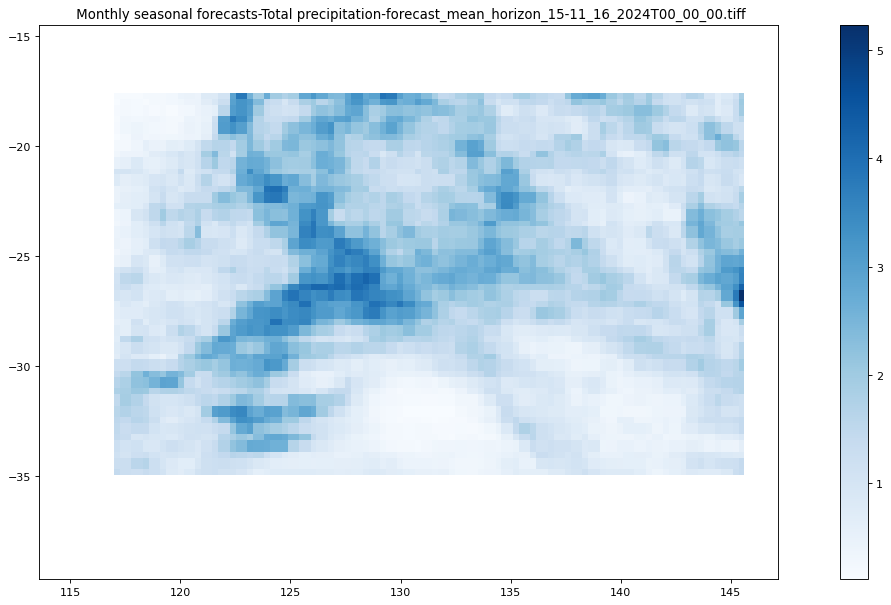

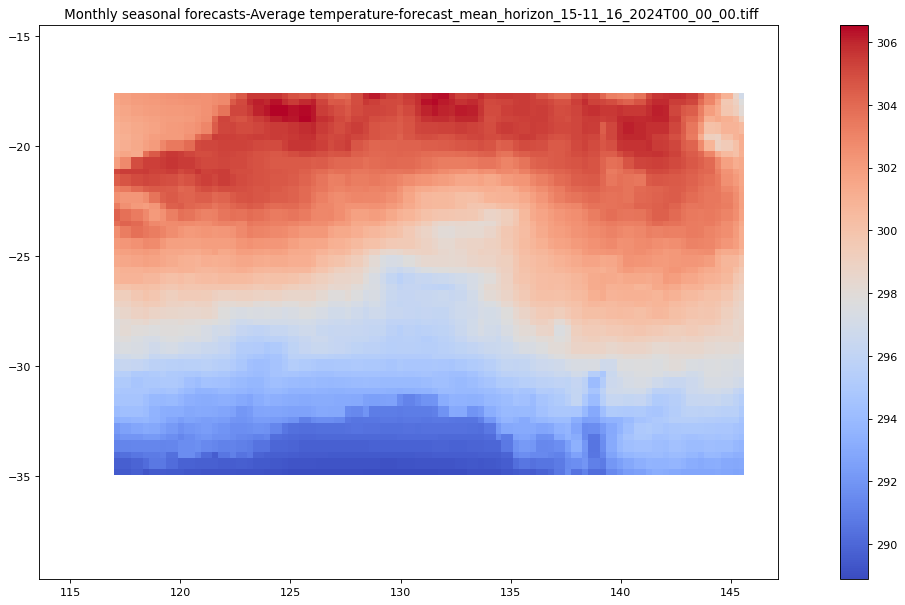

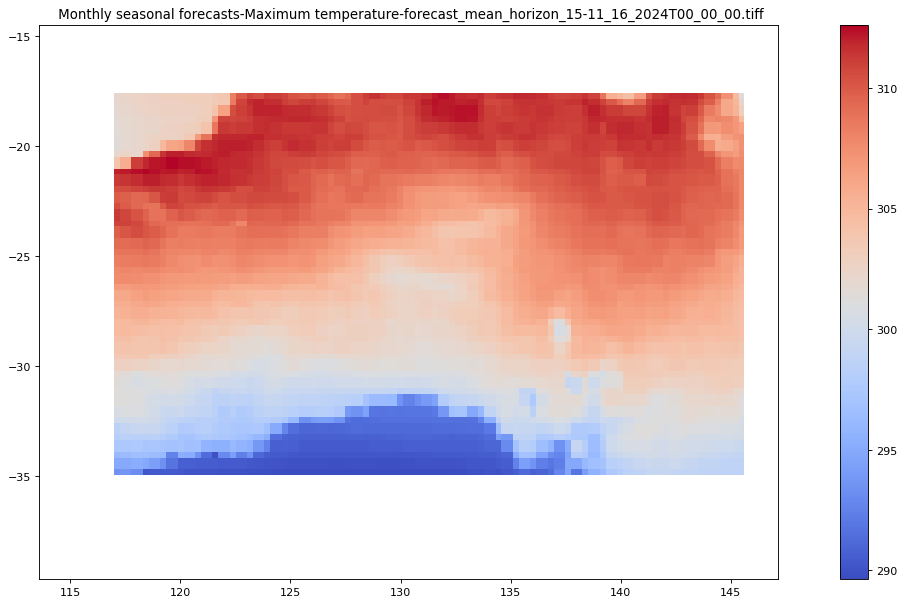

In [92]:
# Function to display the resulting Tiff(s).
TWCSFResult_file_list = TWCSFResult.list_files()
output_image_array = []
for file in TWCSFResult_file_list:
    if file.endswith('.tiff'): #display the raster images
        with open(file+'.json', 'r') as summary_file:
            fileparms = json.load(summary_file)
        boundingBox=fileparms["boundingBox"]
        pixelStatistics=fileparms["rasterStatistics"]
        myextent=[boundingBox["minLongitude"],
                  boundingBox["maxLongitude"],
                  boundingBox["minLatitude"],
                  boundingBox["maxLatitude"]]  
        arrayTWCSF = np.array(PILImage.open(file))
        mask = (arrayTWCSF == -9999)
        # Masked array to exclude NO Data points from plotting
        masked_array = np.ma.masked_array(arrayTWCSF, mask)
        plt.figure(figsize = (20, 9), dpi=80) # Sets the size and resolution of the plot
        if 'temperature' in file:
            plt.imshow(masked_array,cmap = 'coolwarm', 
                       vmin=pixelStatistics["pixelMin"],
                       vmax=pixelStatistics["pixelMax"],
                       extent = myextent) # Loads the raster data and sets the colormap
        else:
            plt.imshow(masked_array,cmap = 'Blues', 
                       vmin=pixelStatistics["pixelMin"], 
                       vmax=pixelStatistics["pixelMax"],
                       extent = myextent) # Loads the raster data and sets the colormap
        plt.colorbar() # Adds the color bar
        plt.title(" "+os.path.basename(file)) 
        output_image_path = os.path.splitext(os.path.basename(file))[0] + ".png"
        plt.savefig(output_image_path, bbox_inches='tight')
        output_image_array.append(output_image_path)
        plt.close()

for output_image in output_image_array:
    #display the raster images
    display(Image(output_image,width=800, height=400))

Each of the images above represents information on different climate variables for the specified location and temporal time period. The color gradient provides a visual representation of the magnitude and distribution of the climate data, making it easier to interpret regional differences and trends in climate conditions.

### References
- https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5
- https://www.ibm.com/docs/en/spss-modeler/saas?topic=nodes-twc-source-node